In [2]:
# We knew most of the solutions in the portfolio where its application of robust risk optimization.
#Hence, we dont need to use solver or corresponding functions in Scipy/ Numpy Library

In [1]:
import numpy as np
from numpy.linalg import det, inv, eigvals

import scipy
from scipy.optimize import minimize, LinearConstraint, Bounds

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mu_i = 0.1
sig_ii = 0.3
rho_ij = 0.25
n = 10

gamma = 1

In [3]:
mu = np.full(n, mu_i)
Sigma = np.full((n, n), rho_ij*sig_ii*sig_ii)

# Set the diagonal elements to the diagonal value
np.fill_diagonal(Sigma, sig_ii*sig_ii)


### Nominal Portfolio

In [15]:
# All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
bounds = Bounds(0, 1)

# Set the constraint that the sum of weights equals 1.
ones_for_sum = np.ones((1, n))
linear_constraint = LinearConstraint(ones_for_sum, [1], [1])

initial_weights = np.ones(n) / n


def objective_nom(a, Sigma): #calculate portfolio risk
    return (gamma/2)*np.dot(a, np.dot(a, Sigma))- np.dot(a, mu)

# Minimize the risk function using the 'trust-constr' method with linear constraint and bounds.
res = minimize(objective_nom, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds, args = (Sigma))
a_hat = res.x
print("Optimal Weights:", a_hat)

# The corresponding relative entropy with this is zero, because we haven't changed the distribution
E_Va = objective_nom(a_hat, Sigma)

Optimal Weights: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


### Worst Case Portfolio

In [5]:
# Plan- calculate the entrophy using explicit expression
# Calculate the max mean-variance objective using simulations?

In [6]:
I = np.eye(n)

#speciific case for analysis
theta_ = 0.2

def objective_a_oftheta(a, theta):
    term1 = 1 / np.sqrt(det(I - theta * gamma * np.outer(a,a) @ Sigma))
    return (1/theta)*np.log(term1) + a.T @ mu

def positive_definite_constraint(a, theta):
    eigenvalues = eigvals(inv(Sigma) - theta * gamma * np.outer(a,a) )
    return np.min(eigenvalues) - 1e-10  # Ensure all eigenvalues are slightly greater than zero


In [34]:
# monte-carlo sampling optimization, because the above one does not works
n_points = 100000
points_on_hyperplane = np.zeros((n_points, 10))

for j in range(n_points):
    random_numbers = np.random.rand(10)
    # Normalize the numbers so their sum is 10
    normalized_numbers = random_numbers / random_numbers.sum() 

    points_on_hyperplane[j] = normalized_numbers

In [35]:
min_eig_vals = np.apply_along_axis(positive_definite_constraint, axis=1, arr=points_on_hyperplane, theta = theta_)
first_positive = np.argmax(min_eig_vals > 0)
a0 = points_on_hyperplane[first_positive]

C:\Users\prith\anaconda3\Lib\site-packages\numpy\lib\shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


In [36]:
print(first_positive, a0)

0 [0.19063644 0.04372    0.1246579  0.15955892 0.03842917 0.11254156
 0.06942072 0.07948461 0.00455775 0.17699293]


In [37]:
# Initial guess for 'a'
#a0 = points_on_hyperplane[1]

# Define constraints in the format required by 'minimize'
constraints = [
    {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)},
    linear_constraint
] 

# Perform the optimization
result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))

# Check if the optimization was successful
if result.success:
    a_star = result.x
    print("Optimized a:", a_star)
    print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
else:
    print("Optimization failed:", result.message)

Optimized a: [0.10003899 0.09997648 0.10001044 0.10002628 0.09997312 0.10000523
 0.09998676 0.09999098 0.09995871 0.10003302]
 Minimum adjective reached at 0.11466794592169285 Not portfolio objective!


C:\Users\prith\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


In [38]:
# Using the Monte Carlo based approximate optimization, if the above method does not work
# Segregating out the invalid portfolio vectors
indices = np.where(min_eig_vals < 0)[0]
# Observation. All the segregated out indices produce nan value in the objective evaluation !

objective_val = np.apply_along_axis(objective_a_oftheta, axis=1, arr=points_on_hyperplane, theta = theta_)
min_arg = np.nanargmin(objective_val)
a_star2 = points_on_hyperplane[min_arg]

In [39]:
print("Optimized a:", a_star2)
print(" Minimum adjective reached at", objective_val[min_arg])

Optimized a: [0.10208299 0.10287419 0.1106846  0.10851892 0.09098528 0.08963041
 0.10535194 0.09491924 0.11131909 0.08363333]
 Minimum adjective reached at 0.11469641424441078


In [40]:
#computaion of entropy, risk_measuremennt
#mvo = mean variance objective
Sigma_tilda = inv(inv(Sigma) - theta_ * gamma * np.outer(a_star, a_star))

entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2

RPs_nominal = objective_nom(a_star, Sigma)
NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)

risk_meas2 = -np.dot(a_star, mu) + (gamma/2)*np.dot(a_star, np.dot(a_star, Sigma_tilda))
# Both of them are the same

Scipy optimize based optimization

In [41]:
# Trying to find a feasible starting point-
n_points = 1000
checking_points = np.zeros((n_points, 10))

for j in range(n_points):
    p = np.zeros(10)
    # Generate random values for the first 9 coordinates
    curr_sum = 0
    for i in range(9):
        p[i] = np.random.uniform(0, 1 - curr_sum)
        curr_sum += p[i]
    p[9] = 1 - curr_sum

    checking_points[j] = p

In [42]:
results_ = {}
thetas = (np.exp(np.linspace(0, 0.4)) - 1)[1:]
for theta in thetas:
    # Calculate worst-case covariance matrix
    Sigma_worst_case = inv(inv(Sigma) - theta * gamma * np.outer(a_hat, a_hat))
    # Calculate performance in the worst-case model
    NP_worst_case = objective_nom(a_hat, Sigma_worst_case)
    
    min_eig_vals = np.apply_along_axis(positive_definite_constraint, axis=1, arr=points_on_hyperplane, theta = theta_)
    first_positive = np.argmax(min_eig_vals > 0)
    a0 = points_on_hyperplane[first_positive]

    constraints = [
    {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)},
    linear_constraint
    ] 
    
    # Perform the optimization
    result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))
    
    # Check if the optimization was successful
    if result.success:
        a_star = result.x
        print("Optimized a:", a_star)
        print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
    else:
        print("Optimization failed:", result.message)
    
    #computaion of entropy, risk-measurement
    Sigma_tilda = inv(inv(Sigma) - theta * gamma * np.outer(a_star, a_star))
    
    entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2
    
    RPs_nominal = objective_nom(a_star, Sigma)
                    
    #NPs_worstcase = objective_nom(a_hat, Sigma_tilda)
    RPs_worstcase = objective_nom(a_star, Sigma_tilda)
    
    results_[theta] = (entropy, RPs_nominal, NP_worst_case, RPs_worstcase)

Optimized a: [0.10003899 0.09997648 0.10001044 0.10002628 0.09997312 0.10000523
 0.09998676 0.09999098 0.09995871 0.10003302]
 Minimum adjective reached at 0.11466794592169285 Not portfolio objective!
Optimized a: [0.10003899 0.09997648 0.10001044 0.10002628 0.09997312 0.10000523
 0.09998676 0.09999098 0.09995871 0.10003302]
 Minimum adjective reached at 0.11466794592169285 Not portfolio objective!
Optimized a: [0.10003899 0.09997648 0.10001044 0.10002628 0.09997312 0.10000523
 0.09998676 0.09999098 0.09995871 0.10003302]
 Minimum adjective reached at 0.11466794592169285 Not portfolio objective!
Optimized a: [0.10003899 0.09997648 0.10001044 0.10002628 0.09997312 0.10000523
 0.09998676 0.09999098 0.09995871 0.10003302]
 Minimum adjective reached at 0.11466794592169285 Not portfolio objective!
Optimized a: [0.10003899 0.09997648 0.10001044 0.10002628 0.09997312 0.10000523
 0.09998676 0.09999098 0.09995871 0.10003302]
 Minimum adjective reached at 0.11466794592169285 Not portfolio object

In [30]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results_.items()]

# Create a DataFrame
df_wc = pd.DataFrame(data_list, columns=['Theta', 'Entropy', 'RPs_nominal', 'NPs_worstcase', 'RPs_worstcase'])

Using Monte carlo sample based approximate optimization

In [42]:
results2_ = {}
thetas = (np.exp(np.linspace(0, 2)) - 1)[1:]
for theta in thetas:

    def objective_t(a):
        return objective(theta, a)
        
    def positive_definite_constraint_t(a):
        return positive_definite_constraint(theta, a)
    
    min_eig_vals = np.apply_along_axis(positive_definite_constraint_t, axis=1, arr=points_on_hyperplane)
    
    no_invalid = np.sum(np.real(min_eig_vals) < 0)
    if (no_invalid):
        print("No of invalid points for theta=", theta, "hyperplane:", no_invalid)
    
    objective_val = np.apply_along_axis(objective_t, axis=1, arr=points_on_hyperplane)
    min_arg = np.nanargmin(objective_val)
    a_star = points_on_hyperplane[min_arg]
    
    #computaion of entropy, 
    Sigma_tilda = inv(inv(Sigma) - theta * gamma * np.outer(a_star, a_star))
    
    entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2
    
    RPs_nominal = objective_nom(a_star)
    NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
    RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)
    
    results2_[theta] = (entropy, RPs_nominal, NPs_worstcase, RPs_worstcase)

C:\Users\prith\anaconda3\Lib\site-packages\numpy\lib\shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


In [139]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results2_.items()]

# Create a DataFrame
df_wc1 = pd.DataFrame(data_list, columns=['Theta', 'Entropy', 'Risk'])

In [145]:
df_wc1

,Theta,Entropy,Risk
0,0.000000,2.664535e-15,-0.072834
1,0.041661,4.001459e-07,-0.084810
2,0.085057,1.670896e-06,-0.084790
3,0.130261,3.926053e-06,-0.084769
4,0.177349,7.291430e-06,-0.084747
5,0.226398,1.190606e-05,-0.084724
6,0.277491,1.792353e-05,-0.084700
7,0.330712,2.551346e-05,-0.084675
8,0.386151,3.486314e-05,-0.084649
9,0.443899,4.617929e-05,-0.084622


In [31]:
df_wc

,Theta,Entropy,RPs_nominal,NPs_worstcase,RPs_worstcase
0,0.008197,1.437494e-08,-0.085375,-0.085371,-0.085371
1,0.016461,5.799073e-08,-0.085375,-0.085368,-0.085368
2,0.024792,1.315951e-07,-0.085375,-0.085364,-0.085364
3,0.033192,2.359509e-07,-0.085375,-0.085361,-0.085361
4,0.041661,3.718367e-07,-0.085375,-0.085357,-0.085357
5,0.050199,5.400466e-07,-0.085375,-0.085353,-0.085353
6,0.058807,7.413913e-07,-0.085375,-0.085350,-0.085350
7,0.067486,9.766975e-07,-0.085375,-0.085346,-0.085346
8,0.076236,1.246809e-06,-0.085375,-0.085342,-0.085342
9,0.085057,1.552586e-06,-0.085375,-0.085339,-0.085339


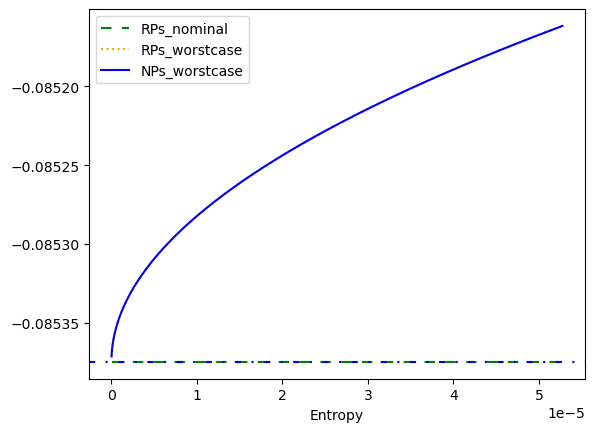

In [33]:
ax = plt.gca()
df_wc.plot(ax = ax, x='Entropy',y='RPs_nominal', linestyle=(0, (5, 5)), linewidth=1.5, color='green')
ax.axhline(y = E_Va, color = 'b', linestyle = (0, (3, 5, 1, 5)))
df_wc.plot(ax = ax, x='Entropy',y='RPs_worstcase', linestyle='dotted', linewidth=1.5, color='orange')
df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue')
plt.show()